In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d

# make a directory for figures
!mkdir figures

from os.path import basename, exists
def download(url):
    fileName = basename(url)
    if not exists(fileName):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, fileName)
        print(f'Downloaded {local}')

download('https://github.com/wernadsky/test/raw/master/cell2d.py')
download('https://github.com/wernadsky/test/raw/master/utils.py')

from cell2d import Cell2D, draw_array, three_frame
from utils import decorate

A subdirectory or file figures already exists.


In [2]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# make a custom color map
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0]
cmap = LinearSegmentedColormap.from_list('cmap', colors)

#### Schelling's model of segregation

In [3]:
class Schelling(Cell2D):
    def __init__(self, n, p):
        """ n: int - размер сетки
            p: float - доля необходимых для счастья себе подобных соседей
        """
        self.p = p
        choises = [0, 1, 2]     # 0 - пустой, 1 - красный агент, 2 - синий
        probs = [0.1, 0.45, 0.45]   # распределение
        # 10% пустых клеток, и по 45% занимают красные и синие агенты
        self.array = np.random.choice(choises, (n, n), p=probs)

    kernel = np.array( [[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]], dtype=np.int8)

    def countNieghbors(self):
        """ Анализ соседства клеток
        возвращает 4 массива nxn, содержащие:
            empty: True, если клетка пустая, False - если нет
            fracRed: долю красных клеток среди всех соседей
            fracBlue: долю синих клеток среди всех соседей
            fracSame: долю соседей с тем же цветом, nan для пустых клеток
        """ 
        a = self.array
        # создаются boolean массивы для индикации клеток
        empty = a==0
        red = a==1
        blue = a==2

        options = dict(mode='same', boundary='wrap')
        # массив будут содержать количество соседних красных/синих клеток:
        numRed = correlate2d(red, self.kernel, **options)
        numBlue = correlate2d(blue, self.kernel, **options)
        numNeighbors = numRed + numBlue     # общее количество соседей
        
        # доля красных/синих соседних клеток:
        fracRed = numRed / numNeighbors
        fracBlue = numBlue / numNeighbors
        
        # массив будет содержать долю красных для красных клеток и долю
        # синих для не красных клеток:
        fracSame = np.where(red, fracRed, fracBlue)
        # массив fracSacme бутет той же формы, что и red, но в соответствии
        # со значением элемента из red, возьмет элемент либо из fracRed,
        # либо из fracBlue, т.е. red содержит условия выбора элементов

        # элементам fracSacme, которым соответствует значение True в 
        # массиве empty присваивается nan:
        fracSame[empty] = np.nan    # <=> fracSame[empty is None] = np.nan

        return (empty, fracRed, fracBlue, fracSame)

    def segregation(self):
        """ Возвращает среднее значение доли
        себеподобных соседей для всех непустых клеток
        """
        _, _, _, fracSame = self.countNieghbors()
        return np.nanmean(fracSame)

    def step(self):
        """Производится шаг симуляции
        возвращает: среднюю долю себеподобных клеток
        """

        a = self.array
        empty, _, _, fracSame = self.countNieghbors()

        # теперь можно получить массив не счастливых агентов:
        unhappy = fracSame < self.p

        # сотавим список координат не счастливых агентов; функция nonzero
        # возвращает индексы ненулевых элементов в виде кортежа одномерных
        # массивов, по одному на каждое измерение массива 
        nz = np.nonzero(unhappy)   # кортеж из двух элментов
        # далее сшиваем эти два кортежа функцией zip и превращаем в list
        unhappyLocs = list(zip(*nz))

        # аналогично получим список координат пустых клеток:
        emptyLocs = list(zip(*np.nonzero(empty)))

        # перемешаем список unhappyLocs:
        if len(unhappyLocs):
            np.random.shuffle(unhappyLocs)

        # каждую несчастливую клетку переместим в случайную пустую клетку
        # это будет происходить за счет обмена элементов между массивами
        # unhappyLocs и emptyLocs, после чего 
        numEmpty = np.sum(empty)    # количество пустых клеток
        for sourse in unhappyLocs:
            i = np.random.randint(numEmpty)     # выбирается случайная
            destination = emptyLocs[i]          # координата пустой клетки

            # перемещение
            a[destination] = a[sourse]  
            a[sourse] = 0
            emptyLocs[i] = sourse   # координата освободившейся клетки

            # проверим, не изменилось ли число пустых клеток:
            numEmpty2 = np.sum(a==0)
            assert numEmpty == numEmpty2
        
        return np.nanmean(fracSame)

    def draw(self, size=None):
        return draw_array(self.array, size, cmap=cmap, vmax=2)


0.4955992509363295

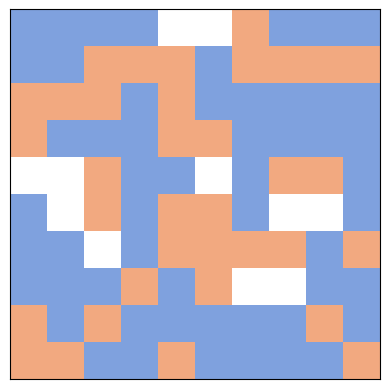

In [5]:
# небольшой образец
grid = Schelling(n=10, p=0.3)
grid.draw()
grid.segregation()

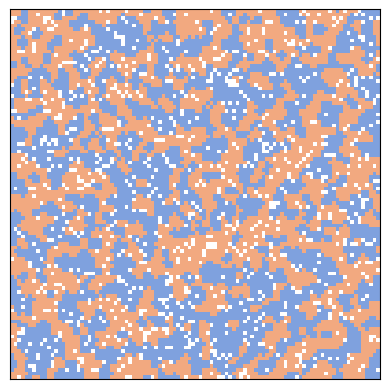

segregation before 0.49856555098409877
segregation after  0.7522684310018904


In [6]:
# запуск процесса
grid = Schelling(n=100, p=0.3)
seg_1 = grid.segregation()
fig = grid.animate(frames=30, interval=0.1)
seg_2 = grid.segregation()
print(f'segregation before {seg_1}')
print(f'segregation after  {seg_2}')

#### Sugarscape

In [4]:
from utils import make_locs
make_locs(4, 5)

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4]])

In [5]:
def distancesFrom(n, i, j):
    """Вычисляется матрица nxn, содержащая расстояния от элементов
    от элемента с индексом (i, j)"""
    X, Y = np.indices((n, n))
    # np.hypot возвращает для двух катетов значение гипотенузы;
    # для двух матриц, пара элементов будет представлять собой катеты;
    # вернется матрица, содержащая гипотенузы для каждой пары элементов
    return np.hypot(X-i, Y-j)

def makeVisibleLocs(vision):
    """Вычисляется kernel видимых клеток
    
    vision: int, видимый радиус 
    """
    def makeArray(d):
        """Генерация четырех координат, находящихся на расстоянии d"""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a

    arrays = [makeArray(d) for d in range(1, vision+1)]
    return np.vstack(arrays) # располагает элементы arrays вертикально

In [13]:
class Sugarscape(Cell2D):
    """Представляет сахарный ландшафт Эпштейна-Акстелла"""
    def __init__(self, n, **params):
        self.n = n
        self.params = params

        self.agentCountSeq = []     # отслеживание численности клеток

        # инициализация сахарной вместимости клеток:
        self.capacity = self.makeCapacity()

        # иницаилизация распределения сахара (изначально
        # все сахарные емкости полные):
        self.array = self.capacity.copy()

        self.makeAgents()           # создание агентов

    def makeCapacity(self):
        """Создание матрицы емкостей клеток"""

        # вычисляется матрица расстояний для каждой клетки от пиков
        dist1 = distancesFrom(self.n, 15, 15)   # пик 1
        dist2 = distancesFrom(self.n, 35, 35)   # пик 2
        dist = np.minimum(dist1, dist2)

        # емкости клеток устанавливаются в соответствии с 
        # расстоянием от пиков:

        bins = [21, 16, 11, 6]
        A = np.digitize(dist, bins, right=False)
        # элемент A будет иметь значение 0, если значение элемента d
        # матрицы dist лежит между 21 и 16 и тд.. 
        return A

    def makeAgents(self):

        # определяем область, в которой будут созданы агенты
        n, m = self.params.get('startingBox', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # создаем агентов
        numAgents = self.params.get('numAgents', 400)
        assert(numAgents <= len(locs))
        self.agents = [Agent(locs[i], self.params)
                        for i in range(numAgents)]
        
        # сохраняем множество координат, занятых агентами
        self.occupied = set(agent.loc for agent in self.agents)

    def grow(self):
        """Добавляется сахар в каждую не насыщенную клетку"""
        growRate = self.params.get('growRate', 1)
        self.array = np.minimum(self.array + growRate, self.capacity)

    def lookAndMove(self, center, vision):
        """Нахождение наиболее богатой сахаром клетки в видимом радиусе
        
        center: tuple, координаты клетки
        vision: int, радиус видимости клетки

        returns: tuple, координаты лучшей клетки
        """
        # поиск координат всех видимых клеток
        locs = makeVisibleLocs(vision)
        locs = (locs + center) % self.n
        # после % self.n все элементы  меньше self.n останутся неизменны
        # а для элементов >= self.n (координаты выходящие за пределы
        # матрицы) значение будет соответствовать координатам, как если
        # бы мир был бы замкнут в тор

        locs = [tuple(loc) for loc in locs]

        # отбираются свободные от агентов клетки:
        emptyLocs = [loc for loc in locs if loc not in self.occupied]

        # если все клетки заняты, оставаться на месте:
        if len(emptyLocs) == 0:
            return center
        
        # собираем значения уровня сахара для пустых клеток
        t = [self.array[loc] for loc in emptyLocs]

        # находим [первый] индекс клетки с наибольшим уровнем сахара
        i = np.argmax(t)
        return emptyLocs[i]
        
    def harvest(self, loc):
        """Удаляет и возвращает сахар из клетки с координатами loc
        loc: tuple, координаты
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar

    def step(self):
        replace = self.params.get('replace', False)

        # перестановка агентов для рандомного порядка обхода
        randomOrder = np.random.permutation(self.agents)
        for agent in randomOrder:
            # удаляем локацию клетки из множества занятых локаций:
            self.occupied.remove(agent.loc)

            agent.step(self)
            # в ходе этого шага агент находит наиболее богатую сахаром
            # клетку в видимо радиусе и перемещается в эту клетку,
            # съедая весь сахар в ней; увеличивается возраст клетки

            # если агент умерает, то удалем его из списка агентов
            if agent.isStarving() or agent.isOld():
                self.agents.remove(agent)
                if replace:
                    self.addAgent()
            else:   # иначе добавляем новую локацию агента
                self.occupied.add(agent.loc)

        # добавляем в последовательность текущее количество агентов:
        self.agentCountSeq.append(len(self.agents))
        
        # рост уровня сахара:
        self.grow()
        return len(self.agents)
    
    def addAgent(self):
        """Генерируется новый случайный агент (Agent)
        """
        newAgent = Agent(self.randomLoc(), self.params)
        self.agents.append(newAgent)
        self.occupied.add(newAgent.loc)
        return newAgent

    def randomLoc(self):
        """Выбор случайной не занятой клетки
        return: tuple, координата
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc
    
    def draw(self, size=None):
        # отрисовка клеток
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')

        # отрисовка агентов
        xs, ys = self.getCoords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]

    def getCoords(self):
        """Возвращает tuple координат агентов для отрисовки.
        Трансформирует (row, col) в (x, y) 
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

In [14]:
class Agent:
    def __init__(self, loc, params):
        """Создается новый агент в заданной локации
        loc: кортеж координат
        params: словарь параметров
        """
        self.loc = tuple(loc)   # координата клетки
        self.age = 0            # возраст клетки

        # распаковка параметров
        maxVision = params.get('maxVision', 6)
        maxMetabolism = params.get('maxMetabolism', 4)
        minLifespan = params.get('minLifespan', 10000)
        maxLifespan = params.get('maxLifespan', 10000)
        minSugar = params.get('minSugar', 5)
        maxSugar = params.get('maxSugar', 25)

        # инициализация свойств
        self.vision = np.random.randint(1, maxVision+1)
        self.metabolism = np.random.uniform(1, maxMetabolism)
        self.lifespan = np.random.uniform(minLifespan, maxLifespan)
        self.sugar = np.random.uniform(minSugar, maxSugar)

    def step(self, env):
        """Разведываени, движение и питание
        env: Sugarscape
        """
        self.loc = env.lookAndMove(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def isStarving(self):
        """Проверяется, не стало ли значение sugar отриацтельным"""
        return self.sugar < 0
    
    def isOld(self):
        """Проверяется, не иссякло ли время жизни"""
        return self.age > self.lifespan
        

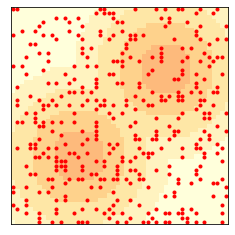

In [8]:
env = Sugarscape(50, numAgents=400)
env.draw()

#### Визуализация распределений параметров агентов

No handles with labels found to put in legend.


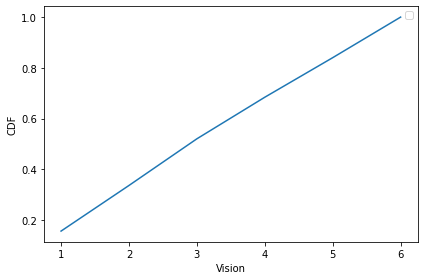

In [18]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(agent.vision for agent in env.agents)
cdf.plot()
decorate(xlabel='Vision', ylabel='CDF')

In [ ]:
cdf = Cdf.from_seq(agent.metabolism for agent in env.agents)
cdf.plot()
decorate(xlabel='Metabolism', ylabel='CDF')

In [ ]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Sugar', ylabel='CDF')

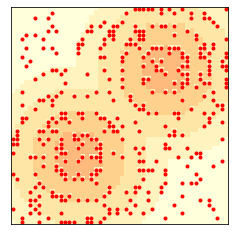

In [106]:
env.step()
env.draw()

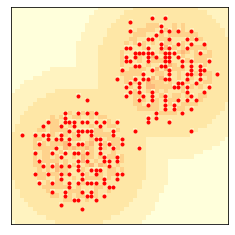

232

In [108]:
fig = env.animate(frames=50)
len(env.agents)

No handles with labels found to put in legend.


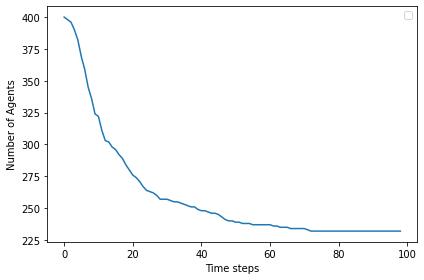

In [110]:
plt.plot(env.agentCountSeq)
decorate(xlabel='Time steps', ylabel='Number of Agents')

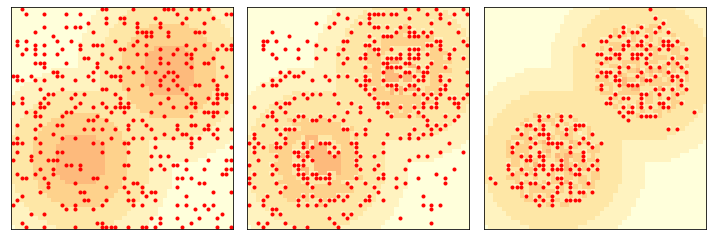

In [11]:
env = Sugarscape(50, num_agents=400)
fig = three_frame(env, [0, 2, 98])

fig.savefig('figures/chap09-3')

### Sugarscape with finite lifespans

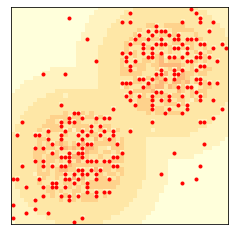

In [16]:
env = Sugarscape(50, 
                 numAgents=250,
                 minLifespan=60, 
                 maxLifespan=100, 
                 replace=True)

fig = env.animate(frames=100)

#### Migration in waves

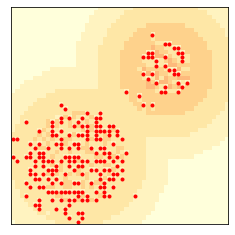

In [27]:
np.random.seed(17)

env = Sugarscape(50, 
                 numAgents=300, 
                 startingBox=(20, 20), 
                 maxVision=16)
    
fig = env.animate(frames=20, interval=0.4)

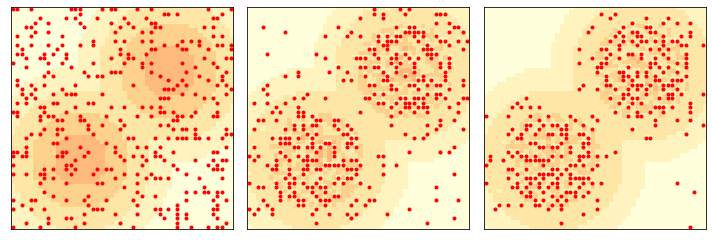

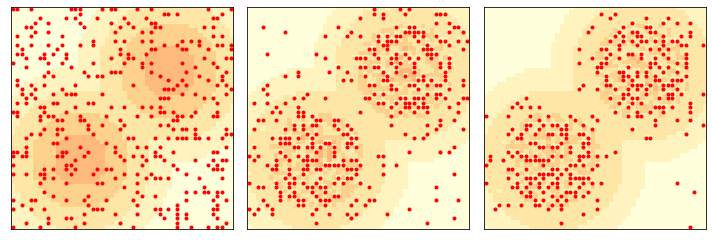

In [24]:
env = Sugarscape(50, num_agents=300, starting_box=(20, 20), max_vision=16)
three_frame(env, [0, 6, 6])